In [6]:
import io
from pathlib import Path 
import zipfile
from functools import reduce

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

import talib
# from madigan.modelling.net.utils import calc_conv_out_shape, calc_pad_to_conserve

sns.set_theme('notebook')
sns.set_style('darkgrid')
figsize(8, 8)

In [7]:
datapath = Path("/media/hemu/Data/Markets/FX/truefx/GBPJPY-zip")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
def read_and_parse_truefx(filepath):
    df = pd.read_csv(filepath, header=None, parse_dates=True)
    df.columns = ('asset', 'timestamp', 'bid', 'ask')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.drop('asset', axis=1).set_index('timestamp')

In [9]:
def load_and_aggregate_truefx(filepaths, timeframe='1h'):
    dfs = []
    for file in tqdm(filepaths):
        df = read_and_parse_truefx(file)
        df = df.resample(timeframe).last().dropna()
        dfs.append(df)
    return pd.concat(dfs)

In [10]:
files = list(datapath.iterdir())
files.sort()
print(len(files))

trn_df = load_and_aggregate_truefx(files[:50], '1h')
tst_df = load_and_aggregate_truefx(files[50: 60], '1h')

125


length:  25183 
                          bid      ask
timestamp                            
2009-05-01 00:00:00  146.130  146.169
2009-05-01 01:00:00  145.952  146.000
2009-05-01 02:00:00  146.120  146.173
2009-05-01 03:00:00  146.110  146.144
2009-05-01 04:00:00  145.910  145.984
length:  5080 
                          bid      ask
timestamp                            
2013-07-01 00:00:00  151.082  151.189
2013-07-01 01:00:00  151.084  151.107
2013-07-01 02:00:00  151.045  151.091
2013-07-01 03:00:00  151.069  151.092
2013-07-01 04:00:00  151.215  151.253


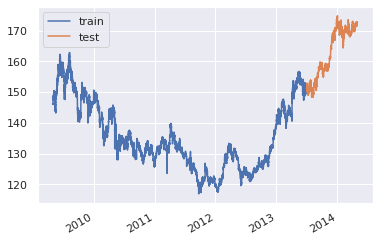

In [11]:
# %matplotlib notebook
%matplotlib inline
print('length: ', len(trn_df), '\n', trn_df.head())
print('length: ', len(tst_df), '\n', tst_df.head())
fig, ax = plt.subplots()
ax.plot(trn_df.mean(axis=1), label='train')
ax.plot(tst_df.mean(axis=1), label='test')
ax.legend()
fig.autofmt_xdate()

In [12]:
x = trn_df.mean(1)
talib.MAX(x[:30])[-1], x.max()

(148.92149999999998, 162.848)

In [13]:
def make_ta_feature_matrix(data, functions, timeperiods):
    assert len(functions) == len(timeperiods)
    orig_dtype = data.dtype
    data = data.astype(np.float64)
    features = []
    for i, func in enumerate(functions):
        feat = func(data, timeperiods[i])
        if isinstance(feat, np.ndarray):
            features.append(feat)
        elif isinstance(feat, tuple):
            for _feat in feat:
                if isinstance(_feat, np.ndarray):
                    features.append(_feat)
                else:
                    raise ValueError("Unexpected output from talib func")
        else:
            raise ValueError("Unexpected output from talib func")
    return np.stack(features, axis=1).astype(orig_dtype)


In [14]:
class FixedWindow(torch.utils.data.Dataset):
    def __init__(self, df, window_length, functions: tuple, timeperiods: tuple):
        assert len(functions)
        assert all([callable(func) for func in functions])
        self.k = window_length
        self.timeperiods = timeperiods
        self.max_timeperiod = max(self.timeperiods)
        data = []
        feats = []
        data_vector = df.mean(axis=1).to_numpy().astype(np.float32)
        for i in range(self.k, len(data_vector)):
            dat = data_vector[i-self.k: i]
            dat = (dat-dat.mean()) / dat.std()
            feat = make_ta_feature_matrix(dat, functions, timeperiods)
            if np.sum(np.isnan(feat[self.k:])) > 0:
                print('nan')
            data.append(dat)
            feats.append(feat[self.max_timeperiod:])
        self.data = np.stack(data)
        self.features = np.stack(feats)
#         self.features = make_ta_feature_matrix(self.data, functions, timeperiods)
        self._n_feats = self.features.shape[2]
    
    @property
    def n_feats(self):
        return self._n_feats
    
    @property
    def input_length(self):
        return self.k
    
    @property
    def output_length(self):
        return self.k - self.max_timeperiod
    
    def __len__(self):
        return len(self.data) - self.k
    
    def __getitem__(self, idx):
#         if isinstance(idx, slice):
#             idx = slice(idx.start+self.k, idx.stop+self.k)
#         else:
#             idx = idx + self.k
        if isinstance(idx, (int, slice)):
            return self.data[idx], self.features[idx], idx
        else: raise ValueError("idx into dataset should be int or slice")
#         data = (self.data[idx - self.k: idx])
# #         data = (data - data.mean()) / data.std()
#         y = self.features[idx - self.k+self.max_timeperiod: idx]
#         mean = data.mean()
#         std = data.std()
#         return (data-mean)/std, (y-mean)/std, idx
#         return (data-data.mean())/data.std(), (y-y.mean(axis=0))/y.std(axis=0), idx

In [15]:
functions = [talib.MAX, talib.MIN, talib.SMA, talib.BBANDS]
window_length=128
timeperiods=[32, 32, 32, 32]
dset = FixedWindow(trn_df, window_length, 
                   functions, timeperiods)
x, y = dset[1000][:2]
print('full dset shapes x, y: ', dset.data.shape, dset.features.shape)
print('x data point shape', x.shape)
print('y data point shape', y.shape)
print('x', x[:5])
print('y', y[:5])

full dset shapes x, y:  (25055, 128) (25055, 96, 6)
x data point shape (128,)
y data point shape (96, 6)
x [1.8816943 1.9160172 1.9251966 1.9588591 1.9568911]
y [[1.9588591  0.47304198 1.1629823  2.1224554  1.1629823  0.20350923]
 [1.9588591  0.47304198 1.1362926  2.0572338  1.1362926  0.21535152]
 [1.9588591  0.47304198 1.1122603  1.9886595  1.1122603  0.2358612 ]
 [1.9568911  0.47304198 1.0907556  1.9152389  1.0907556  0.26627234]
 [1.7695528  0.47304198 1.0679667  1.8336453  1.0679667  0.302288  ]]


## Model

In [16]:
act_fn_dict = {'tanhshrink': nn.Tanhshrink, 'relu': nn.ReLU, 'silu': nn.SiLU,
              'gelu': nn.GELU, 'none': lambda: lambda x: x}

In [17]:
class AE_MLP(nn.Module):
    """
        Symmetric - number of encoding layers == number of deconding layers
    """
    def __init__(self, input_size, output_size, d_model, n_layers):
        super().__init__()
        self.inp_sz = input_size
        self.act_fn = nn.GELU()
        bias = False
        layers = [nn.Linear(input_size, d_model, bias=bias), self.act_fn]
        for i in range(n_layers):
            layers.append(nn.Linear(d_model, d_model))
            layers.append(self.act_fn)
        layers.append(nn.Linear(d_model, output_size))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
#         with torch.no_grad():
#             norm = x[:, -1][..., None]
#             x = x / norm
        # NORMALIZE
#         mean = x.mean(-1, keepdim=True)
#         std = x.std(-1, keepdim=True)
        x = (x - mean) / std
        y = self.layers(x)
        # DENORMALIZE
#         y = (y* std) + mean
        return y

In [175]:
from typing import Union
class ConvLayerNorm(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
        
    def forward(self, x):
        return self.norm(x.transpose(-1, -2)).transpose(-1, -2)
    
class ConvBlock(nn.Module):
    def __init__(self, input_length: int, channels_in: int, channels_out: int, kernel: int, 
                 stride: int, dilation: int, bias: bool, groups: int,
                 padding: Union[int, tuple], maxpool_kernel: int, 
                 act: str, residual: bool = False):
        super().__init__()
        if residual:
            if channels_in != channels_out:
                raise ValueError("channels in must equal channels out if resisudal=True")
        self.residual = residual
        self.conv = conv = nn.Conv1d(channels_in, channels_out,
                         kernel, 
                         stride=stride,
                         dilation=dilation,
                         bias=bias, 
                         groups=groups,
                    )
        self.pad = nn.ReplicationPad1d(padding)
        self.act = act_fn_dict[act]()
        self.norm = nn.BatchNorm1d(channels_out)
        self.maxpool = nn.MaxPool1d(maxpool_kernel, stride)
        dummy_input = torch.randn(1, channels_in, input_length)
        input_length = self.maxpool(self.pad(self.conv(dummy_input))).shape[-1]
#         self.norm = nn.LayerNorm(input_length)
#         self.norm = ConvLayerNorm(channels_out)
        
    def forward(self, x):
        if self.residual:
            res = x
        x = self.act(self.pad(self.conv(x)))
        x = self.maxpool(x)
        if self.residual:
            x = res + self.norm(x)
        else:
            x = self.norm(x)
        return x
    
class AE_CNN(nn.Module):
    """
    AutoEncoder using 1D convolutions
    After the bottleneck (of size encoded_size)
    """
    def __init__(self, input_size, output_size, output_feats, 
                 channels, kernels, strides, dilations, groups,
                 d_fc, dropout=0.1, residual_connections=False,
                 act='tanhshrink', bias=False):
        super().__init__()
        assert len(strides) == len(channels) == len(kernels)
        maxpool_kernels = kernels
        self.inp_sz = input_size
        self.out_sz = output_size
        self.out_feats = output_feats
        self.d_fc = d_fc
        self.dropout = nn.Dropout(dropout)
        self.act = act_fn_dict[act]()
#         self.act = nn.SiLU()
        bias = bias
        channels = [1] + channels
        layers=[]
        input_length = input_size
        for i in range(1, len(channels)):
#             padding = (kernels[i-1]-1)//2
            padding = (kernels[i-1]-1, 0)  # causal padding
            _groups=min(max(channels[i-1]//groups, 1), groups)
            print(_groups)
            res = residual_connections if i>1 else False
            conv_block = ConvBlock(input_length,
                                   channels[i-1], channels[i],
                                   kernels[i-1], strides[i-1],
                                   dilations[i-1], bias, _groups,
                                   padding, maxpool_kernels[i-1],
                                   act, res)
            layers.append(conv_block)
            input_length = conv_block(torch.randn(1, channels[i-1], input_length)).shape[-1]
        self.conv_layers = nn.Sequential(*layers)
        dummy_input = torch.randn(1, 1, self.inp_sz)
        conv_output_size = self.conv_layers(dummy_input).shape[-1]
        output_kernel = 5
        self.output_pool = nn.AdaptiveMaxPool1d(output_size+output_kernel-1)
        self.conv_out = nn.Conv1d(channels[-1], output_feats, output_kernel,
                                  stride=1)
        
    def forward(self, x):
        x = x[..., None].transpose(1, -1)
        x = self.act(self.conv_layers(x))
        x = self.dropout(self.output_pool(x))
        x = self.conv_out(x)
        return x.transpose(-1, -2)

In [176]:
def model_size(model):
     return reduce(lambda x,y:x+y,
                   [reduce(lambda x,y:x+y, p.shape)
                    for p in model.parameters()])

# Training and Evaluation

In [177]:
def trainer(model, dataloader, device, lr=1e-3):
    loss_fn = nn.MSELoss()
#     loss_fn = nn.L1Loss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    print_freq = max(len(dataloader) // 100, 100)
    model.train()
    for i, (x, y, idx) in enumerate(iter(dataloader)):
        opt.zero_grad()
        x = x.to(device)
        pred = model(x)
        loss = loss_fn(pred, y.to(device))
        loss.backward()
        opt.step()
        _loss = loss.detach().item()
        yield _loss
        if i % print_freq == 0:
            print(_loss, end='\r', flush=True)
        
@torch.no_grad()
def test(model, dataloader, device):
    loss_fn_l1 = nn.L1Loss(reduction='none')
    loss_fn_l2 = nn.MSELoss(reduction='none')
    losses_l1 = []
    losses_l2 = []
    xs = []
    ys = []
    preds = []
    model.eval()
    for i, (x, y, idx) in enumerate(iter(dataloader)):
        x = x.to(device)
        pred = model(x)
        loss_l1 = loss_fn_l1(pred, y.to(device))
        losses_l1.append(loss_l1.detach().cpu().numpy())
        loss_l2 = loss_fn_l2(pred, y.to(device))
        losses_l2.append(loss_l2.detach().cpu().numpy())
        xs.append(x.cpu().numpy())
        ys.append(y)
        preds.append(pred.cpu().numpy())
    return {'loss_l1': np.concatenate(losses_l1).mean(1),
            'loss_l2': np.concatenate(losses_l2).mean(1),
            'x': np.concatenate(xs), 'pred': np.concatenate(preds),
            'y': np.concatenate(ys)}
        

In [178]:
def show_performance(metrics, batch_idx, feature_names, title="",
                     x_offset=None, figsize=(15, 15)):
    x_offset = x_offset or 0
    num_feats = len(feature_names) 
    assert num_feats == metrics['y'].shape[-1]
    fig, ax = plt.subplots(num_feats+1, 1, figsize=figsize)
    ax[0].set_title('input timeseries', loc='left')
    ax[0].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    ax[0]._frameon = False
    ax[0].axis('off')
    for i, feat in enumerate(feature_names):
        _ax = ax[i+1]
        row_title = f"{feat} l1_loss: {metrics['loss_l1'][:, i].mean(): .5f}" + \
        f" l2_loss: {metrics['loss_l2'][:, i].mean(): .5f}"
        _ax.set_title(row_title, fontsize=12, loc='left')
        _ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        _ax._frameon = False
        _ax.axis('off')
    # first row is just the timeseries input
    for i in range(4):
        _ax = fig.add_subplot(num_feats+1, 4, i+1)
        _ax.plot(metrics['x'][batch_idx+i][x_offset:], label='x')
        _ax.legend()
    # next rows are features
    for i, feat in enumerate(feature_names):
        for j in range(4):
            _ax = fig.add_subplot(num_feats+1, 4, 4*(i+1) + j+1)
            dat_y = metrics['y'][batch_idx+j, :, i]
            dat_pred = metrics['pred'][batch_idx+j, :, i]
            _ax.plot(dat_y, label='target')
            _ax.plot(dat_pred, label='pred')
            _ax.legend()
    fig.suptitle(title)
#     fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.subplots_adjust(hspace=0.5)
    return fig, ax


### DataLoaders Instantiation

In [179]:
batch_size = 64
window_length=128
RSI = lambda x, timeperiod: talib.RSI(x, timeperiod) / 100
RSI.__name__ = "RSI"
functions = [RSI]
timeperiods = [16]
functions = [talib.VAR, talib.MAX, talib.MIN, talib.EMA, RSI]
timeperiods=[16, 16, 16, 16, 16]
function_names = [func.__name__ for func in functions]

trn_dset = FixedWindow(trn_df, window_length, functions, timeperiods)
tst_dset = FixedWindow(tst_df, window_length, functions, timeperiods)
trnloader = torch.utils.data.DataLoader(trn_dset, batch_size=batch_size, 
                                        shuffle=True)
tstloader = torch.utils.data.DataLoader(tst_dset, batch_size=batch_size, 
                                        shuffle=True)

### Model Instantiation

In [198]:
d_model = 32
encoded_size = 8
d_fc = 128
channels = [16, 16, 16, 16]
strides = [1]*len(channels)
kernels = [4, 4, 4, 4]
dilations = [1]*len(channels)
groups = 2
dropout = 0.2
residual_connections = False
# act = 'tanhshrink'
# act = 'none'
act = 'silu'
# act = 'gelu'
bias = True

model = AE_CNN(trn_dset.input_length, trn_dset.output_length, trn_dset.n_feats,
               channels, kernels, strides=strides, dilations=dilations,
               groups=groups, d_fc=d_fc, dropout=dropout, 
               residual_connections=residual_connections, act=act,
               bias=bias).to(device)
print('model size', model_size(model))
print('len of train dataset', len(trn_dset))
print('len of test dataloader', len(trnloader))

1
2
2
2
model size 328
len of train dataset 24927
len of test dataloader 390


In [199]:
# Test forward pass

x, y = (dat.to(device) for dat in next(iter(trnloader))[:2])
pred = model(x)
assert y.shape == pred.shape, print(pred.shape, y.shape)

In [200]:
losses = []

In [ ]:
epochs =  300

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in tqdm(range(epochs)):
    train_loop = iter(trainer(model, trnloader, device))
    for loss in train_loop:
        losses.append(loss)
    

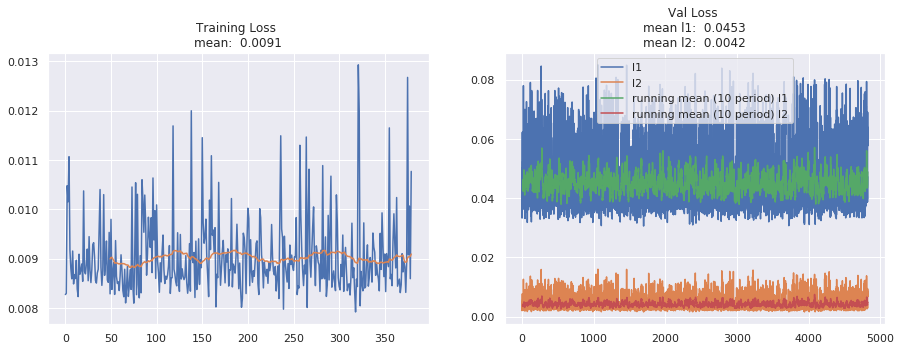

In [205]:
metrics = test(model, tstloader, device)
figsize(15, 5)
fig, ax = plt.subplots(1, 2)
ax[0].plot(losses[-len(trnloader)+10:])
ax[0].plot(pd.Series(losses[-len(trnloader)+10:]).rolling(50).mean(),
          label='running mean (50 period)')
ax[0].set_title(f'Training Loss \nmean: {np.mean(losses[(len(losses)//2):]): .4f}')
ax[1].plot(metrics['loss_l1'].mean(-1), label='l1')
ax[1].plot(metrics['loss_l2'].mean(-1), label='l2')
ax[1].plot(pd.Series(metrics['loss_l1'].mean(-1)).rolling(10).mean(),
          label='running mean (10 period) l1')
ax[1].plot(pd.Series(metrics['loss_l2'].mean(-1)).rolling(10).mean(),
          label='running mean (10 period) l2')
ax[1].set_title(f"Val Loss \n"+ 
                f"mean l1: {np.mean(metrics['loss_l1']): .4f}\n" +
                f"mean l2: {np.mean(metrics['loss_l2']): .4f}")
_=ax[1].legend()

In [203]:
batch_idx = 0

/home/hemu/miniconda3/envs/madigan/lib/python3.7/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


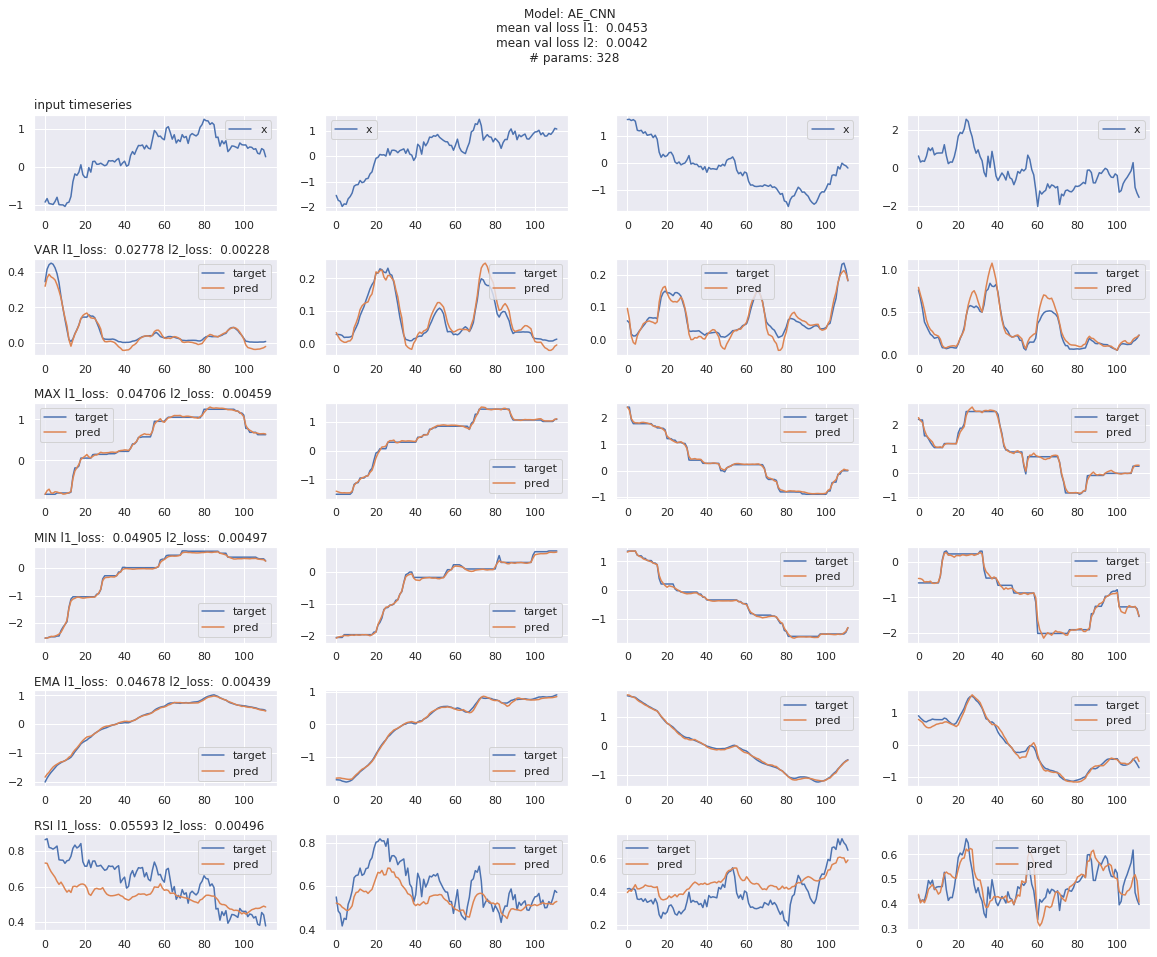

In [204]:
title =  f"Model: {type(model).__name__}  \n" + \
         f"mean val loss l1: {np.mean(metrics['loss_l1']): .4f} \n" + \
         f"mean val loss l2: {np.mean(metrics['loss_l2']): .4f} \n" + \
         f"# params: {model_size(model)}"
fig, ax = show_performance(metrics, batch_idx, function_names, title=title,
                           x_offset=tst_dset.max_timeperiod, figsize=(20,15)); batch_idx += 1


In [119]:
list(model.modules())

[AE_CNN(
   (dropout): Dropout(p=0.2, inplace=False)
   (act): SiLU()
   (conv_layers): Sequential(
     (0): ConvBlock(
       (conv): Conv1d(1, 16, kernel_size=(4,), stride=(1,))
       (pad): ReplicationPad1d((3, 0))
       (act): SiLU()
       (maxpool): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
       (norm): LayerNorm((125,), eps=1e-05, elementwise_affine=True)
     )
     (1): ConvBlock(
       (conv): Conv1d(16, 16, kernel_size=(4,), stride=(1,), groups=2)
       (pad): ReplicationPad1d((3, 0))
       (act): SiLU()
       (maxpool): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
       (norm): LayerNorm((122,), eps=1e-05, elementwise_affine=True)
     )
     (2): ConvBlock(
       (conv): Conv1d(16, 16, kernel_size=(4,), stride=(1,), groups=2)
       (pad): ReplicationPad1d((3, 0))
       (act): SiLU()
       (maxpool): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
       (norm): LayerNorm